# Research Notebook: Development of SAC Reinforcement Learning Model for Stock Trading

## Team Members:
- Javon Kitson
- Nathan Metheny
- Kobe Mensah

---

## Notebook Introduction

This Jupyter notebook serves as a detailed documentation and workspace for our research and development process in creating a Soft Actor-Critic (SAC) reinforcement learning model tailored for stock trading. The notebook is structured to guide through the various stages of model development, from data handling to final evaluation.


## Notebook Objectives

1. **Dataset Handling and Preparation**: To detail the process of acquiring, cleaning, and preparing the stock price data for model training.
2. **Feature Engineering**: To explore and define the set of features that will be used by the SAC model, enhancing its ability to make informed trading decisions.
3. **Model Development**: To document the iterative process of designing, training, and tuning the SAC model.
4. **Evaluation and Testing**: To assess the model's performance using historical data, focusing on its ability to make profitable trading decisions.

## Dataset
First Rate Data: https://firstratedata.com/cb/4/complete-stocks-etf \
Volume: 262GB \
Unique Tickers: 10120 ~7k Stocks + ~3k ETFs

---

### Data Engineering

- Overview of the data source and its characteristics.
- Steps taken for data cleaning and preprocessing.
- Strategies for data storage and retrieval.

### Feature Engineering

- Identification and justification of chosen features for the model.
- Detailed explanation of the feature engineering process.
- Analysis of the impact of these features on the model’s performance.


### Model Development

- Detailed description of the SAC algorithm and its suitability for stock trading.
- Architecture of the Actor and Critic networks within the SAC framework.
- Hyperparameter selection and optimization process.

### Training Process

- Methodology for training the SAC model using the prepared dataset.
- Techniques employed for improving model performance and avoiding overfitting.
- Continuous evaluation during the training phase.

### Model Evaluation and Testing

- Criteria and metrics for model evaluation, including profitability and Sharpe Ratio.
- Testing process using the validation and test datasets.
- Comparison of model performance against traditional trading strategies.

## Environment Setup

In [14]:
# AWS CLI and AWS Python SDK (boto3)
!pip install --disable-pip-version-check -q awscli==1.18.216 boto3==1.16.56 botocore==1.19.56

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awswrangler 3.7.1 requires boto3<2.0.0,>=1.20.32, but you have boto3 1.16.56 which is incompatible.
awswrangler 3.7.1 requires botocore<2.0.0,>=1.23.32, but you have botocore 1.19.56 which is incompatible.
sagemaker-studio-analytics-extension 0.0.20 requires boto3<2.0,>=1.26.49, but you have boto3 1.16.56 which is incompatible.


In [15]:
# SageMaker
!pip install --disable-pip-version-check -q sagemaker==2.29.0
!pip install --disable-pip-version-check -q smdebug==1.0.1
!pip install --disable-pip-version-check -q sagemaker-experiments==0.1.26

In [16]:
# PyAthena
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [17]:
# AWS Data Wrangler
!pip install --disable-pip-version-check -q awswrangler

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.18.216 requires botocore==1.19.56, but you have botocore 1.34.66 which is incompatible.
awscli 1.18.216 requires s3transfer<0.4.0,>=0.3.0, but you have s3transfer 0.10.1 which is incompatible.


In [18]:
# Zip
!conda install -y zip

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



# All requested packages already installed.



In [19]:
!python -m pip install TA-Lib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
!conda install -y -c conda-forge ta-lib

Solving environment: / 

In [ ]:
!conda install -y -c conda-forge libta-lib

In [ ]:
# Matplotlib
!pip install --disable-pip-version-check -q matplotlib==3.1.3

In [ ]:
# Seaborn
!pip install --disable-pip-version-check -q seaborn==0.10.0

In [ ]:
!pip install protobuf==3.20.0 holidays

In [ ]:
pip install --upgrade seaborn numpy -q

In [ ]:
!python --version
!pip list

## Imports

In [ ]:
import os
import boto3
import talib
import warnings
import holidays
import sagemaker
import pandas as pd
import numpy as np
import awswrangler as wr
from pyathena import connect
from sagemaker.session import Session
from time import time, gmtime, strftime
from sagemaker.feature_store.feature_group import FeatureGroup
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

## Data Engineering

In [ ]:
sess = sagemaker.Session()
bucket = "stockdata90210"
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
print("Default bucket: {}".format(bucket))

In [ ]:
!aws s3 ls "stockdata90210"

In [ ]:
database_name = "stockdata"

In [ ]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [ ]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

### Create Athena Database

In [61]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS stockdata


In [ ]:
pd.read_sql(statement, conn)

/tmp/ipykernel_41/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


### Verify The Database Has Been Created Succesfully

In [ ]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

### Create Meta Data Tables

#### Stock Universe

##### Create Athena Table

In [ ]:
database_name = "stockdata"
table_name_tsv = "universe"
s3_private_path_tsv = "s3://{}/universe/".format(bucket)
print(s3_private_path_tsv)

s3://stockdata90210/universe/


In [24]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Ticker string,
         Name string,
         First_Date string,
         Last_Date string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_tsv, s3_private_path_tsv
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS stockdata.universe(
         Ticker string,
         Name string,
         First_Date string,
         Last_Date string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://stockdata90210/universe/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [25]:
pd.read_sql(statement, conn)

/tmp/ipykernel_985/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


##### Verify The Table Has Been Created Succesfully

In [ ]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

##### Run A Sample Query

In [86]:
product_category = "ticker"

statement = """SELECT * FROM {}.{} LIMIT 100""".format(
    database_name, table_name_tsv, product_category
)

In [87]:
print(statement)
df = pd.read_sql(statement, conn)
df.head(5)

SELECT * FROM stockdata.universe LIMIT 100


/tmp/ipykernel_41/973613919.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,ticker,name,first_date,last_date
0,A,Agilent Technologies Inc,2005-01-03,2023-04-21
1,AA,Alcoa Corporation,2016-10-18,2023-04-21
2,AACG,Ata Creativity Global American Depositary Shares,2008-01-29,2023-04-21
3,AADI,Aadi Bioscience,2017-08-08,2023-04-21
4,AAIC,Arlington Asset Investment Class A,2009-06-10,2023-04-21


#### Company Profiles

##### Create Athena Table

In [ ]:
database_name = "stockdata"
table_name_tsv = "company_profile"
s3_private_path_tsv = "s3://{}/company_profile/".format(bucket)
print(s3_private_path_tsv)

In [112]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         `Ticker` string,
         `Company Name` string,
         `Country` string,
         `State` string,
         `Exchange` string,
         `Sector` string,
         `Industry` string,
         `Ipo Date` string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_tsv, s3_private_path_tsv
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS stockdata.company_profile(
         `Ticker` string,
         `Company Name` string,
         `Country` string,
         `State` string,
         `Exchange` string,
         `Sector` string,
         `Industry` string,
         `Ipo Date` string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://stockdata90210/company_profile/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [113]:
pd.read_sql(statement, conn)

/tmp/ipykernel_41/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


##### Verify The Table Has Been Created Succesfully

In [ ]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

##### Run A Sample Query

In [99]:
product_category = "ticker"

statement = """SELECT * FROM {}.{} LIMIT 100""".format(
    database_name, table_name_tsv, product_category
)

In [100]:
print(statement)
df = pd.read_sql(statement, conn)
df.head(5)

SELECT * FROM stockdata.universe LIMIT 100


/tmp/ipykernel_985/973613919.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,ticker,name,first_date,last_date
0,A,Agilent Technologies Inc,2005-01-03,2023-04-21
1,AA,Alcoa Corporation,2016-10-18,2023-04-21
2,AACG,Ata Creativity Global American Depositary Shares,2008-01-29,2023-04-21
3,AADI,Aadi Bioscience,2017-08-08,2023-04-21
4,AAIC,Arlington Asset Investment Class A,2009-06-10,2023-04-21


#### Stock Tables

##### Move tickers to individual folders

In [202]:
s3_client = boto3.client('s3')
original_prefix = '1min/Stocks/'

def move_files_to_own_folder():
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix=original_prefix)

    for page in page_iterator:
        if 'Contents' in page:  # Check if the page has contents
            for item in page['Contents']:
                file_key = item['Key']
                if file_key.endswith('/'):  # Skip directories
                    continue

                # Skip files that are already in the correct format
                path_parts = file_key.split('/')
                if len(path_parts) == 4 and path_parts[-1].startswith(path_parts[-2]):
                    print(f"Skipping already processed file: {file_key}")
                    continue

                print(f"Processing: {file_key}")
                
                # Extract the file name
                file_name = os.path.basename(file_key)
                # Create a new folder name by stripping off '_full_1min_adjsplitdiv.txt'
                new_folder_base = file_name.replace('_full_1min_adjsplitdiv.txt', '')
                new_folder_path = f"{original_prefix}{new_folder_base}/"
                # Define the new key for the file within its new folder
                new_file_key = f"{new_folder_path}{new_folder_base}.txt"
                print(f"New file path: {new_file_key}")

                # Copy the file to the new location
                copy_source = {'Bucket': bucket_, 'Key': file_key}
                s3_client.copy_object(Bucket=bucket, CopySource=copy_source, Key=new_file_key)
                
                # Delete the original file
                s3_client.delete_object(Bucket=bucket, Key=file_key)
                
                print(f"Moved {file_key} to {new_file_key}")

move_files_to_own_folder()

Skipping already processed file: 1min/Stocks/A/A.txt
Skipping already processed file: 1min/Stocks/AA/AA.txt
Skipping already processed file: 1min/Stocks/AABA-DELISTED/AABA-DELISTED.txt
Skipping already processed file: 1min/Stocks/AACG/AACG.txt
Skipping already processed file: 1min/Stocks/AADI/AADI.txt
Skipping already processed file: 1min/Stocks/AAIC/AAIC.txt
Skipping already processed file: 1min/Stocks/AAL/AAL.txt
Skipping already processed file: 1min/Stocks/AAMC/AAMC.txt
Skipping already processed file: 1min/Stocks/AAME/AAME.txt
Skipping already processed file: 1min/Stocks/AAN/AAN.txt
Skipping already processed file: 1min/Stocks/AAOI/AAOI.txt
Skipping already processed file: 1min/Stocks/AAON/AAON.txt
Skipping already processed file: 1min/Stocks/AAP/AAP.txt
Skipping already processed file: 1min/Stocks/AAPL/AAPL.txt
Skipping already processed file: 1min/Stocks/AAT/AAT.txt
Skipping already processed file: 1min/Stocks/AATC-DELISTED/AATC-DELISTED.txt
Skipping already processed file: 1min/

##### Create Athea Tables

In [142]:
# Initialize Boto3 clients
original_prefix = '1min/Stocks/'  # Include trailing slash
database_name = "stockdata"

def auto_create_tables():
    total_items = 0
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix=original_prefix)


    for page in page_iterator:
        if 'Contents' in page:  # Check if the page has contents
            for item in page['Contents']:
                file_key = item['Key']
                if file_key.endswith('/'):  # Skip directories
                    continue
                
                
                # Extract directory and table name
                directory, _ = os.path.split(file_key)
                path_parts = file_key.split('/')
                if len(path_parts) < 3:  # Ensure there's enough parts
                    continue

                table_name = path_parts[2] + "_1min"
                table_name = table_name.replace("-", "_").replace(".", "_")
                #print(table_name)
                s3_private_path_tsv = "s3://{}/{}".format(bucket, directory)
                #print(s3_private_path_tsv)
                total_items +=1

                # Drop the existing table
                drop_statement = f"DROP TABLE IF EXISTS {database_name}.{table_name}"
                pd.read_sql(drop_statement, conn)
                
                # Corrected SQL statement
                statement = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
                        Timestamp timestamp,
                        Open float,
                        High float,
                        Low float,
                        Close float,
                        Volume int
                ) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{s3_private_path_tsv}/'"""
                
                # Print statement for debugging
                print(statement)
                
                pd.read_sql(statement, conn)

In [ ]:
auto_create_tables()

##### Verify The Table Has Been Created Succesfully - 7017 tickers, 1 universe, 1 company profile - 7019

In [43]:
import pandas as pd

statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)

total_tables = len(df_show)

print("Total number of tables:", total_tables)

Total number of tables: 7128


In [55]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,a_1min
1,aa_1min
2,aaba_delisted_1min
3,aacg_1min
4,aadi_1min


##### Run A Sample Query

In [45]:
print(table_name_tsv)

universe


In [46]:
product_category = "ticker"

table_name_tsv = table_name_tsv.lower()
# table_name_tsv = table_name_tsv + "_1min"

statement = """SELECT * FROM {}.{} LIMIT 100""".format(
    database_name, table_name_tsv, product_category
)

In [47]:
print(statement)
df = pd.read_sql(statement, conn)
df.head(5)

SELECT * FROM stockdata.universe LIMIT 100


/tmp/ipykernel_985/973613919.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,ticker,name,first_date,last_date
0,A,Agilent Technologies Inc,2005-01-03,2023-04-21
1,AA,Alcoa Corporation,2016-10-18,2023-04-21
2,AACG,Ata Creativity Global American Depositary Shares,2008-01-29,2023-04-21
3,AADI,Aadi Bioscience,2017-08-08,2023-04-21
4,AAIC,Arlington Asset Investment Class A,2009-06-10,2023-04-21


## Feature Engineering

In [36]:
region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)

In [37]:
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

In [38]:
feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [40]:
current_time_sec = int(time())
original_prefix = "1min/Stocks/"
offline_prefix = 'featurestore/Stocks'

# stock_feature_group_name = "stock-feature-group-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# print(f"Creating feature group: {stock_feature_group_name}")

# Initialize the feature group
stock_feature_group = FeatureGroup(
    name="stock-feature-group-2024-02-21-18-45-19",
    sagemaker_session=feature_store_session
)   

In [41]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [16]:
# Constants
SMA5_PERIOD = 5  # Period for 5-day Simple Moving Average
ROLLING_WINDOW = 20  # Period for the rolling window used for statistics like Rolling Mean and Rolling Standard Deviation
RSI_PERIOD = 14  # Period for Relative Strength Index (RSI) calculation
EMA_PERIOD = 12  # Period for Exponential Moving Average (EMA) calculation
MACD_FASTPERIOD = 12  # Fast period for Moving Average Convergence Divergence (MACD) calculation
MACD_SLOWPERIOD = 26  # Slow period for MACD calculation
MACD_SIGNALPERIOD = 9  # Signal period for MACD calculation
SMA10_PERIOD = 10  # Period for 10-day Simple Moving Average
SMA20_PERIOD = 20  # Period for 20-day Simple Moving Average
SMA50_PERIOD = 50  # Period for 50-day Simple Moving Average
BBANDS_PERIOD = 20  # Period for Bollinger Bands calculation
ROC_PERIOD = 12  # Period for Rate of Change (ROC) calculation
ATR_PERIOD = 14  # Period for Average True Range (ATR) calculation
CCI_PERIOD = 20  # Period for Commodity Channel Index (CCI) calculation
WILLR_PERIOD = 14  # Period for Williams %R (WILLR) calculation
STOCH_FASTK_PERIOD = 5  # Fast period for Stochastic Oscillator calculation
STOCH_SLOWK_PERIOD = 3  # SlowK period for Stochastic Oscillator calculation
STOCH_SLOWD_PERIOD = 3  # SlowD period for Stochastic Oscillator calculation
MFI_PERIOD = 14  # Period for Money Flow Index (MFI) calculation
us_holidays = holidays.UnitedStates()

In [17]:
def process_data(df):
    # Convert 'Timestamp' to datetime format and sort the data by it
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by='timestamp', inplace=True)
    
    # Calculate day of the week
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
    
    df['is_holiday'] = df['timestamp'].dt.date.apply(lambda x: int(x in us_holidays))
    
    # Compute Unix timestamp
    df['timestamp'] = df['timestamp'].astype('int64') // 10**9
    
    # Calculate Returns - doesnt look right
    df['returns'] = (df['close'] / df['close'].shift(1) - 1)
    
    # Calculate general statistics
    df['avg_Price'] = df["close"].mean()
    df['avg_Returns'] = df['returns'].mean()
    df['volatility'] = df['returns'].std()
    df['volume_Volatility'] = df['volume'].std()

    # Calculate Moving Average and Price and Volume change
    df['moving_Avg'] = df['close'].rolling(window=SMA5_PERIOD).mean()
    df['price_Change'] = df['close'].pct_change() * 100  # Price change percentage
    df['volume_Change'] = df['volume'].diff()  # Difference in volume
    
    # Calculate rolling window statistics
    df['Rolling_Mean'] = df['close'].rolling(window=ROLLING_WINDOW).mean()
    df['Rolling_Std'] = df['close'].rolling(window=ROLLING_WINDOW).std()

    # Technical Indicators
    df['RSI'] = talib.RSI(df['close'], timeperiod=RSI_PERIOD)
    df['EMA'] = talib.EMA(df['close'], timeperiod=EMA_PERIOD)
    df['MACD'] = talib.MACD(df['close'], fastperiod=MACD_FASTPERIOD, slowperiod=MACD_SLOWPERIOD, signalperiod=MACD_SIGNALPERIOD)[0]
    df['SMA_5'] = talib.SMA(df['close'], timeperiod=SMA5_PERIOD)
    df['SMA_10'] = talib.SMA(df['close'], timeperiod=SMA10_PERIOD)
    df['SMA_20'] = talib.SMA(df['close'], timeperiod=SMA20_PERIOD)
    df['SMA_50'] = talib.SMA(df['close'], timeperiod=SMA50_PERIOD)
    upper, middle, lower = talib.BBANDS(df['close'], timeperiod=BBANDS_PERIOD)
    df['BBANDS_Upper'] = upper
    df['BBANDS_Middle'] = middle
    df['BBANDS_Lower'] = lower
    df['VWAP'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()
    df['ROC'] = talib.ROC(df['close'], timeperiod=ROC_PERIOD)
    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=ATR_PERIOD)
    df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=CCI_PERIOD)
    df['WilliamsR'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=WILLR_PERIOD)
    slowk, slowd = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=STOCH_FASTK_PERIOD, slowk_period=STOCH_SLOWK_PERIOD, slowk_matype=0, slowd_period=STOCH_SLOWD_PERIOD, slowd_matype=0)
    df['Stochastic_SlowK'] = slowk
    df['Stochastic_SlowD'] = slowd
    df['MFI'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=MFI_PERIOD)
    
    # Handle missing data
    df = df.ffill().bfill().fillna(0)
    df.dropna(inplace=True)
    
    return df

In [19]:
# Define a function for parallel execution
def process_ticker(ticker):
    print(ticker)

    try:
        timestamp_str = strftime("%Y%m%d%H%M%S", gmtime())
        temp_table_name = f"temp_table_{uuid.uuid4().hex}_{timestamp_str}"
        
        df = wr.athena.read_sql_query(sql=f"SELECT * FROM \"{ticker}\"", database="stockdata")
        df = process_data(df)
    
        # Extract the stock symbol or identifier from the file_key
        stock_identifier = os.path.basename(ticker).split('_')[0]  # Adjust based on your file naming convention
        df["Ticker"] = stock_identifier
        df["EventTime"] = pd.Series([current_time_sec] * len(df), dtype="float64")
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of an error

    return df

In [ ]:
# 96 vCPU + 768GiB

from concurrent.futures import ThreadPoolExecutor
import uuid
# List to store results
dfs = []
chunk_size=20

# Parallel execution for Athena queries
with ThreadPoolExecutor(max_workers=80) as executor:  # Adjust the number of workers based on available CPU
    for i in range(0, len(df_show['tab_name']), chunk_size):
        chunk = df_show['tab_name'][i:i + chunk_size]
        partial_results = list(executor.map(process_ticker, chunk))
        dfs.extend(partial_results)

    results = list(executor.map(process_ticker, df_show['tab_name']))

# Concatenate results,,
df_main = pd.concat(results, ignore_index=True)

print("All tickers processed.")

In [ ]:
# 96 vCPU + 768GiB

from concurrent.futures import ThreadPoolExecutor
import uuid
# List to store results
dfs = []

# Parallel execution for Athena queries
with ThreadPoolExecutor(max_workers=84) as executor:  # Adjust the number of workers based on available CPU
    results = list(executor.map(process_ticker, df_show['tab_name']))

# Concatenate results,,
df_main = pd.concat(results, ignore_index=True)

print("All tickers processed.")

### Create Dataframe

### Create FeatureGroups in SageMaker FeatureStore

In [ ]:
df_main.head()

In [ ]:
# Load feature definitions to the feature group
# Auto-detect the schema based on the dataframe
stock_feature_group.load_feature_definitions(data_frame=df_main)  # This should be done once, schema should be consistent across files

In [ ]:
# Create the feature group
stock_feature_group.create(
    s3_uri=f"s3://{bucket}/{offline_prefix}",
    record_identifier_name="Ticker",
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True
)

In [ ]:
wait_for_feature_group_creation_complete(feature_group=stock_feature_group)

In [42]:
stock_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:914326228175:feature-group/stock-feature-group-2024-02-21-18-45-19',
 'FeatureGroupName': 'stock-feature-group-2024-02-21-18-45-19',
 'RecordIdentifierFeatureName': 'Ticker',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'timestamp',
   'FeatureType': 'Integral'},
  {'FeatureName': 'open', 'FeatureType': 'Fractional'},
  {'FeatureName': 'high', 'FeatureType': 'Fractional'},
  {'FeatureName': 'low', 'FeatureType': 'Fractional'},
  {'FeatureName': 'close', 'FeatureType': 'Fractional'},
  {'FeatureName': 'volume', 'FeatureType': 'Fractional'},
  {'FeatureName': 'day_of_week', 'FeatureType': 'Integral'},
  {'FeatureName': 'is_holiday', 'FeatureType': 'Integral'},
  {'FeatureName': 'returns', 'FeatureType': 'Fractional'},
  {'FeatureName': 'avg_Price', 'FeatureType': 'Fractional'},
  {'FeatureName': 'avg_Returns', 'FeatureType': 'Fractional'},
  {'FeatureName': 'volatility', 'FeatureType': 'Fractional'},
  {'Fe

In [43]:
sagemaker_client.list_feature_groups()

{'FeatureGroupSummaries': [{'FeatureGroupName': 'stock-feature-group-2024-02-21-18-45-19',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:914326228175:feature-group/stock-feature-group-2024-02-21-18-45-19',
   'CreationTime': datetime.datetime(2024, 2, 22, 0, 38, 21, 865000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}}],
 'ResponseMetadata': {'RequestId': 'c328a503-608b-4347-b953-036b7eac4097',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c328a503-608b-4347-b953-036b7eac4097',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '309',
   'date': 'Sun, 17 Mar 2024 23:08:53 GMT'},
  'RetryAttempts': 0}}

# Load feature definitions from the feature store
feature_definitions = feature_store.list_feature_views()### Put Records in FeatureStore

In [ ]:
stock_feature_group.ingest(data_frame=df_main, max_workers=5, wait=True)

In [ ]:
record_identifier_value = str(appl)

featurestore_runtime.get_record(
    FeatureGroupName=stock_feature_group
    RecordIdentifierValueAsString=record_identifier_value
)

In [ ]:
print(stock_feature_group.as_hive_ddf())

# Data Research

## Engineered Stock Data

In [ ]:
database = "stock_engineered"

In [25]:
# Constants
SMA5_PERIOD = 5  # Period for 5-day Simple Moving Average
ROLLING_WINDOW = 20  # Period for the rolling window used for statistics like Rolling Mean and Rolling Standard Deviation
RSI_PERIOD = 14  # Period for Relative Strength Index (RSI) calculation
EMA_PERIOD = 12  # Period for Exponential Moving Average (EMA) calculation
MACD_FASTPERIOD = 12  # Fast period for Moving Average Convergence Divergence (MACD) calculation
MACD_SLOWPERIOD = 26  # Slow period for MACD calculation
MACD_SIGNALPERIOD = 9  # Signal period for MACD calculation
SMA10_PERIOD = 10  # Period for 10-day Simple Moving Average
SMA20_PERIOD = 20  # Period for 20-day Simple Moving Average
SMA50_PERIOD = 50  # Period for 50-day Simple Moving Average
BBANDS_PERIOD = 20  # Period for Bollinger Bands calculation
ROC_PERIOD = 12  # Period for Rate of Change (ROC) calculation
ATR_PERIOD = 14  # Period for Average True Range (ATR) calculation
CCI_PERIOD = 20  # Period for Commodity Channel Index (CCI) calculation
WILLR_PERIOD = 14  # Period for Williams %R (WILLR) calculation
STOCH_FASTK_PERIOD = 5  # Fast period for Stochastic Oscillator calculation
STOCH_SLOWK_PERIOD = 3  # SlowK period for Stochastic Oscillator calculation
STOCH_SLOWD_PERIOD = 3  # SlowD period for Stochastic Oscillator calculation
MFI_PERIOD = 14  # Period for Money Flow Index (MFI) calculation
us_holidays = holidays.UnitedStates()

In [26]:
def process_data(df):
    # Convert 'Timestamp' to datetime format and sort the data by it
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by='timestamp', inplace=True)
    
    # Calculate day of the week
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
    df['month_of_year'] = df['timestamp'].dt.month
    
    df['is_holiday'] = df['timestamp'].dt.date.apply(lambda x: int(x in us_holidays))
    
    # Compute Unix timestamp
    df['timestamp'] = df['timestamp'].astype('int64') // 10**9
    
    # Calculate Returns
    df['returns'] = (df['close'] / df['close'].shift(1) - 1)
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Calculate general statistics
    df['rolling_avg_price'] = df['close'].rolling(window=ROLLING_WINDOW).mean()
    df['rolling_avg_returns'] = df['returns'].rolling(window=ROLLING_WINDOW).mean()
    df['rolling_volatility'] = df['returns'].rolling(window=ROLLING_WINDOW).std()
    df['rolling_volume_volatility'] = df['volume'].rolling(window=ROLLING_WINDOW).std()

    # Calculate Moving Average and Price and Volume change
    df['moving_Avg'] = df['close'].rolling(window=SMA5_PERIOD).mean()
    df['price_Change'] = df['close'].pct_change() * 100  # Price change percentage
    df['volume_Change'] = df['volume'].diff()  # Difference in volume
    
    # Calculate rolling window statistics
    df['Rolling_Mean'] = df['close'].rolling(window=ROLLING_WINDOW).mean()
    df['Rolling_Std'] = df['close'].rolling(window=ROLLING_WINDOW).std()

    # Technical Indicators
    df['RSI'] = talib.RSI(df['close'], timeperiod=RSI_PERIOD)
    df['EMA'] = talib.EMA(df['close'], timeperiod=EMA_PERIOD)
    df['MACD'] = talib.MACD(df['close'], fastperiod=MACD_FASTPERIOD, slowperiod=MACD_SLOWPERIOD, signalperiod=MACD_SIGNALPERIOD)[0]
    df['SMA_5'] = talib.SMA(df['close'], timeperiod=SMA5_PERIOD)
    df['SMA_10'] = talib.SMA(df['close'], timeperiod=SMA10_PERIOD)
    df['SMA_20'] = talib.SMA(df['close'], timeperiod=SMA20_PERIOD)
    df['SMA_50'] = talib.SMA(df['close'], timeperiod=SMA50_PERIOD)
    upper, middle, lower = talib.BBANDS(df['close'], timeperiod=BBANDS_PERIOD)
    df['BBANDS_Upper'] = upper
    df['BBANDS_Middle'] = middle
    df['BBANDS_Lower'] = lower
    df['VWAP'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()
    df['ROC'] = talib.ROC(df['close'], timeperiod=ROC_PERIOD)
    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=ATR_PERIOD)
    df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=CCI_PERIOD)
    df['WilliamsR'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=WILLR_PERIOD)
    slowk, slowd = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=STOCH_FASTK_PERIOD, slowk_period=STOCH_SLOWK_PERIOD, slowk_matype=0, slowd_period=STOCH_SLOWD_PERIOD, slowd_matype=0)
    df['Stochastic_SlowK'] = slowk
    df['Stochastic_SlowD'] = slowd
    df['MFI'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=MFI_PERIOD)
    
    # Handle missing data
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df.ffill().bfill().fillna(0)
    df.dropna(inplace=True)
    
    return df

In [50]:
statement = "SHOW TABLES in {}".format("stockdata")
statement1 = "SHOW TABLES in {}".format("stock_engineered")

df_show = pd.read_sql(statement, conn)
df_exists = pd.read_sql(statement1, conn)

In [51]:
df_show.head(5)

,tab_name
0,a_1min
1,aa_1min
2,aaba_delisted_1min
3,aacg_1min
4,aadi_1min


In [52]:
df_show.shape

(7129, 1)

In [53]:
df_exists.shape

(7018, 1)

In [54]:
df_exists.head(5)

,tab_name
0,a_1min
1,aa_1min
2,aaba_delisted_1min
3,aacg_1min
4,aadi_1min


In [55]:
tables = pd.DataFrame(wr.catalog.get_tables(database="stock_engineered"))

# Print the list of tables and their information
tables.head(5)

,Name,DatabaseName,CreateTime,UpdateTime,Retention,StorageDescriptor,PartitionKeys,TableType,Parameters,CreatedBy,IsRegisteredWithLakeFormation,CatalogId,VersionId,Owner
0,a_1min,stock_engineered,2024-03-18 02:23:42+00:00,2024-03-19 03:11:38+00:00,0,"{'Columns': [{'Name': 'timestamp', 'Type': 'bi...",[],EXTERNAL_TABLE,"{'compressionType': 'snappy', 'classification'...",arn:aws:sts::914326228175:assumed-role/SageMak...,False,914326228175,5,NaN
1,aa_1min,stock_engineered,2024-03-18 02:23:39+00:00,2024-03-19 03:11:28+00:00,0,"{'Columns': [{'Name': 'timestamp', 'Type': 'bi...",[],EXTERNAL_TABLE,"{'compressionType': 'snappy', 'classification'...",arn:aws:sts::914326228175:assumed-role/SageMak...,False,914326228175,5,NaN
2,aaba_delisted_1min,stock_engineered,2024-03-18 02:23:42+00:00,2024-03-19 03:11:38+00:00,0,"{'Columns': [{'Name': 'timestamp', 'Type': 'bi...",[],EXTERNAL_TABLE,"{'compressionType': 'snappy', 'classification'...",arn:aws:sts::914326228175:assumed-role/SageMak...,False,914326228175,5,NaN
3,aacg_1min,stock_engineered,2024-03-18 02:23:25+00:00,2024-03-19 03:11:09+00:00,0,"{'Columns': [{'Name': 'timestamp', 'Type': 'bi...",[],EXTERNAL_TABLE,"{'compressionType': 'snappy', 'classification'...",arn:aws:sts::914326228175:assumed-role/SageMak...,False,914326228175,5,NaN
4,aadi_1min,stock_engineered,2024-03-18 02:23:23+00:00,2024-03-19 03:11:12+00:00,0,"{'Columns': [{'Name': 'timestamp', 'Type': 'bi...",[],EXTERNAL_TABLE,"{'compressionType': 'snappy', 'classification'...",arn:aws:sts::914326228175:assumed-role/SageMak...,False,914326228175,5,NaN


In [34]:
version_id = tables[tables['Name'] == "aapl_1min"]['VersionId'].iloc[0]

In [35]:
version_id

'5'

In [36]:
import awswrangler as wr
from time import gmtime, strftime
import uuid
import os

def process_ticker(ticker):
    print(f"Processing ticker: {ticker}")
    
    # if ticker in df_exists['tab_name'].values:
    #     print(f"Table {ticker} already exists in stock_engineered. Skipping.")
    #     return None
    
    if "temp_table_" in ticker:
        print("temp table ignoring")
        return None
    
    filtered_tables = tables[tables['Name'] == ticker]
    if not filtered_tables.empty:
        version_id = int(filtered_tables['VersionId'].iloc[0])
        if version_id >= 1:
            print(f"Version ID for {ticker} is {version_id}. Skipping.")
            return None
    else:
        print(f"No version ID found for {ticker}, proceeding with processing.")

    try:
        # Create a timestamp string for the temporary table
        timestamp_str = strftime("%Y%m%d%H%M%S", gmtime())
        # Generate a unique temporary table name using UUID
        temp_table_name = f"temp_table_{uuid.uuid4().hex}_{timestamp_str}"
        
        # Read data from the 'stockdata' database using the ticker as the table name
        df = wr.athena.read_sql_query(sql=f"SELECT * FROM \"{ticker}\"", database="stockdata")
        # Process the DataFrame with your previously defined process_data function
        df_processed = process_data(df)
        
        # Save the processed DataFrame to a new table in 'stock_engineered' database
        wr.s3.to_parquet(
            df=df_processed,
            path=f's3://stockdata90210/parquet/{ticker}/',
            dataset=True,
            database='stock_engineered',
            table=ticker,
            mode='overwrite'
        )
        
        print(f"Successfully processed and saved: {ticker}")
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        # Return an empty DataFrame in case of an error
        return pd.DataFrame()
    # Return the processed DataFrame
    return df_processed

In [37]:
# 96 vCPU + 768GiB

from concurrent.futures import ThreadPoolExecutor
import uuid
# List to store results
dfs = []
chunk_size=20

# Parallel execution for Athena queries
with ThreadPoolExecutor(max_workers=40) as executor:  # Adjust the number of workers based on available CPU
    for i in range(0, len(df_show['tab_name']), chunk_size):
        chunk = df_show['tab_name'][i:i + chunk_size]
        partial_results = list(executor.map(process_ticker, chunk))
        dfs.extend(partial_results)

    results = list(executor.map(process_ticker, df_show['tab_name']))

# Concatenate results,,
df_main = pd.concat(results, ignore_index=True)

print("All tickers processed.")

Processing ticker: a_1min
Version ID for a_1min is 5. Skipping.
Processing ticker: aa_1min
Version ID for aa_1min is 5. Skipping.
Processing ticker: aaba_delisted_1min
Processing ticker: aacg_1min
Version ID for aaba_delisted_1min is 5. Skipping.
Processing ticker: aadi_1min
Version ID for aacg_1min is 5. Skipping.
Processing ticker: aaic_1min
Processing ticker: aal_1min
Version ID for aal_1min is 5. Skipping.
Version ID for aaic_1min is 5. Skipping.
Version ID for aadi_1min is 5. Skipping.
Processing ticker: aamc_1min
Version ID for aamc_1min is 5. Skipping.
Processing ticker: aame_1min
Version ID for aame_1min is 5. Skipping.
Processing ticker: aan_1min
Processing ticker: aaoi_1min
Version ID for aaoi_1min is 5. Skipping.
Processing ticker: aaon_1min
Version ID for aaon_1min is 5. Skipping.
Version ID for aan_1min is 5. Skipping.
Processing ticker: aap_1min
Processing ticker: aapl_1min
Version ID for aapl_1min is 5. Skipping.
Processing ticker: aat_1min
Version ID for aat_1min is 5. 

## Create Heatmap

In [49]:
import awswrangler as wr
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def calculate_correlation(ticker):
    try:
        # Read data from 'stock_engineered' database using the ticker as the table name
        df = wr.athena.read_sql_query(sql=f"SELECT * FROM \"{ticker}\"", database="stock_engineered")
        # Drop non-numeric columns before calculating correlation
        numeric_df = df.select_dtypes(include=[np.number])
        correlation_matrix = numeric_df.corr()
        print(f"Correlation matrix for {ticker} calculated.")
        return correlation_matrix
    except Exception as e:
        print(f"Error calculating correlation for {ticker}: {e}")
        return None

In [ ]:
tickers = df_exists['tab_name'].tolist()

In [ ]:
correlation_matrices = []
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(calculate_correlation, ticker) for ticker in tickers]
    for future in futures:
        corr_matrix = future.result()
        if not corr_matrix.empty:
            correlation_matrices.append(corr_matrix)

In [72]:
def remove_nan_correlation_matrices(correlation_matrices):
    non_nan_correlation_matrices = [
        matrix for matrix in correlation_matrices if not matrix.isnull().values.any()
    ]
    return non_nan_correlation_matrices

In [73]:
%%capture clean_gdf

clean_correlation_matrices = remove_nan_correlation_matrices(correlation_matrices)

In [74]:
%%capture gdf

global_correlation_matrix = pd.concat(clean_correlation_matrices).groupby(level=0).mean()

In [75]:
# Sort the columns and index of the average correlation matrix to ensure they are in the same order
sorted_columns = sorted(global_correlation_matrix.columns)
avg_correlation_matrix = global_correlation_matrix.loc[sorted_columns, sorted_columns]

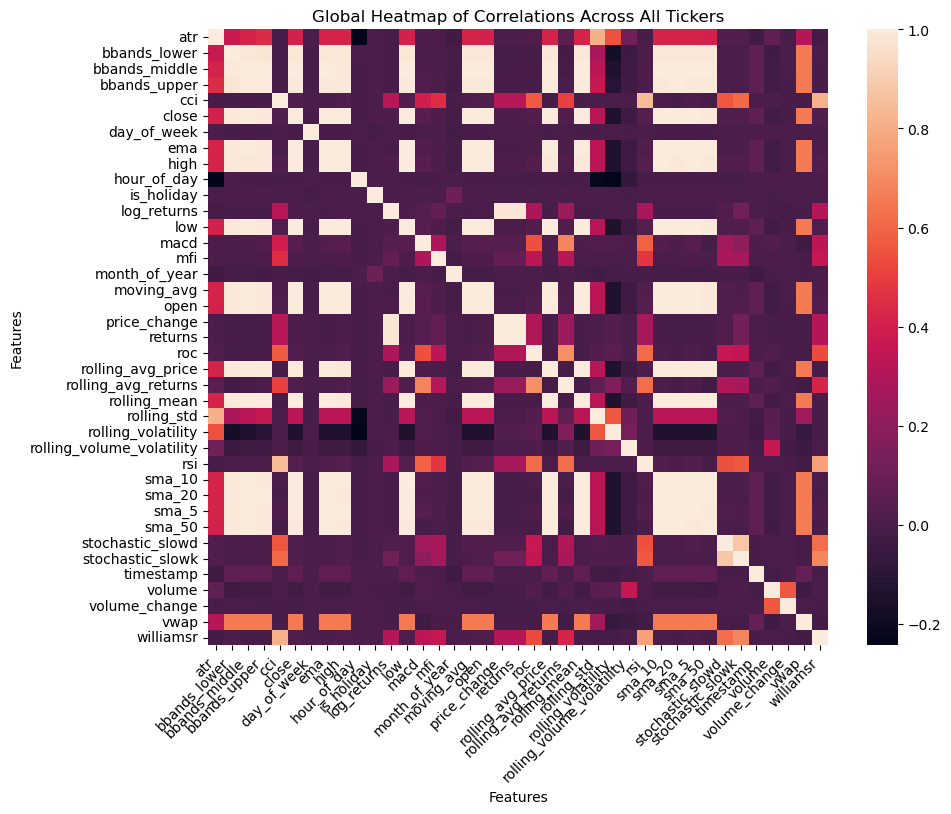

In [83]:
# Plot Global Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_correlation_matrix)
# sns.heatmap(global_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Global Heatmap of Correlations Across All Tickers')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.savefig('global_heatmap.png', bbox_inches='tight')
plt.show() 